In [7]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
import os
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
llm=ChatGroq(model_name="Gemma2-9b-It")

In [8]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**. 🇫🇷 \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_time': 0.027272727, 'prompt_time': 0.001924048, 'queue_time': 0.246054062, 'total_time': 0.029196775}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--ce4e56c2-fb09-4bdb-ab63-c0c6c5b876e1-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31})

# Retriever

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=25
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [54]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [55]:
### Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system1 = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system1),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "figter jets"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [180]:
### Question Re-writer
# Prompt
system2 = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning. Please give me just 2 optimized questions without any additional text."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system2),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'1. fighter jet models\n2. best fighter jets  \n'

In [181]:
# # Run
# question = "tell me about agent memory."
# generation = rag_chain.invoke(question)
# print(generation)

In [182]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]



In [183]:

### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [184]:
web_search_tool.invoke({"query": "fighter jets"})

[{'title': 'Fighter aircraft - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Fighter_aircraft',
  'content': 'Contents\n\nFighter aircraft\n\n\n\nFighter aircraft (early on also pursuit aircraft)[a] are military aircraft designed primarily for air-to-air combat. In military conflict, the role of fighter aircraft is to establish air superiority of the battlespace. Domination of the airspace above a battlefield permits bombers and attack aircraft to engage in tactical and strategic bombing of enemy targets, and helps prevent the enemy from doing the same. [...] A fighter aircraft is primarily designed for air-to-air combat.[4] A given type may be designed for specific combat conditions, and in some cases for additional roles such as air-to-ground fighting. Historically the British Royal Flying Corps and Royal Air Force referred to them as "scouts" until the early 1920s, while the U.S. Army called them "pursuit" aircraft until the late 1940s (using the designation P, as in Curtiss P

In [3]:
from langchain.utilities import GoogleSerperAPIWrapper

search = GoogleSerperAPIWrapper()
result = search.run("who is a current prime minister of USA?")  # ✅ RIGHT
print(result)


In all, 45 individuals have served 47 presidencies spanning 60 four-year terms. Donald Trump is the 47th and current president since January 20, 2025. Donald J. Trump is the 47th and current president of the United States, in office since January 2025. Donald J. Trump serves as the 47th President of the United States. He also served as the 45th. Read the President's full biography. Donald J. Trump ... After a landslide election victory in 2024, President Donald J. Trump is returning to the White House to build upon his previous successes and ... Missing: minister | Show results with:minister. The current Prime Minister is Donald J. Trump. LTC Tulsi Gabbard approaches every issue, domestic and foreign, with a focus on ensuring the safety, security, and freedom of the American people. She is ... Missing: prime | Show results with:prime. Prime Minister Narendra Modi welcomed United States President Joseph R. Biden, Jr., to India today, reaffirming the close and enduring partnership betwee

In [185]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [186]:

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [187]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [188]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [189]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    print(question)
    documents = state["documents"]
    print(documents)

    # Web search
    docs = web_search_tool.invoke(question)
    print(docs)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

# from langchain.schema import Document

# def web_search(state):
#     print("---WEB SEARCH STEP---")
#     question = state.get("question")
#     documents = state.get("documents", [])
#     print("Question:", question)
#     print("Documents:", documents)
#     if not isinstance(question, str) or not question.strip():
#         raise ValueError(f"Invalid or missing 'question': {question}")

#     try:
#         search_results = web_search_tool.invoke({"query": question})
#         web_text = "\n".join([r["content"] if isinstance(r, dict) else str(r) for r in search_results])
#         print("Web search results:", web_text)
#         web_doc = Document(page_content=web_text)
#         documents.append(web_doc)
#         print("documents", documents)
#     except Exception as e:
#         print("Web search failed:", e)
#         # Optionally continue with empty results
#         documents.append(Document(page_content=""))

#     return {"question": question, "documents": documents}


In [190]:


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [191]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [192]:
# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

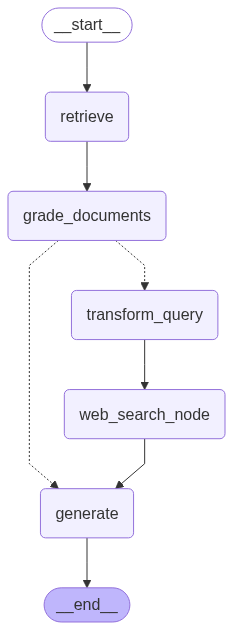

In [195]:
app

In [193]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The document describes two types of agent memory: short-term memory and '
 'long-term memory.  Short-term memory is akin to in-context learning, while '
 'long-term memory stores information over extended periods, often using an '
 'external vector store. \n')


In [194]:
from pprint import pprint

# Run
inputs = {"question": "Taj Mahal"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
What is the Taj Mahal?
Where is the Taj Mahal located? 

[]
[{'title': 'Taj Mahal - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Taj_Mahal', 'content': "The Taj Mahal (/ˌtɑːdʒ məˈhɑːl, ˌtɑːʒ -/ TAHJ mə-HAHL, TAHZH -\u2060; Hindi: [taːdʒ ˈmɛɦ(ɛ)l]; lit.\u2009'Crown of the Palace') is an ivory-white marble mausoleum on the right bank of the river Yamuna in Agra, Uttar Pradesh, India. It was commissioned in 1631 by the fifth Mughal emperor, Shah Jahan (r.\u20091628–1658) to house the tomb of his beloved wife, Mumtaz Mahal; it also houses the tomb o